In [15]:
from utils import u_time as ut
from eod import read_eod as re
import salem
import numpy as np
from scipy.ndimage.measurements import label 
import pyproj
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from wavelet import util
import cleo
import pickle as pkl
pylab.rcParams['figure.figsize'] = 20., 12.
%matplotlib inline

In [2]:
trmm_folder='/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA'
msg_folder='/users/global/cornkle/data/OBS/meteosat_SA15'           

In [3]:
m=re.msg(msg_folder)

In [4]:
t=re.trmm(trmm_folder, yrange=range(2008, 2009), area=[-10, 10, 10, 20]) 

In [5]:
td=t.getDData(2008, 6, 28, 17, 26, cut=[9,21])

2008
Ind: [1]


In [6]:
d1, lat1, lon1=m.getData(y=2008, m=6, d=28, h=17, mi=30, llbox=[t.lon.min(), t.lon.max(), t.lat.min(), t.lat.max() ])

In [7]:
d1[d1>-20]=0

In [8]:
labels, numL = label(d1)

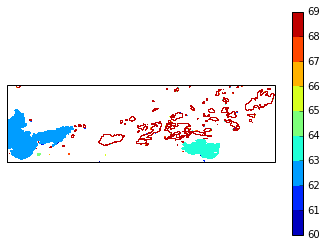

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lon1, lat1, labels, levels=np.arange(60,70,1), transform=ccrs.PlateCarree())
#plt.contourf(m.lon, m.lat, labels, transform=ccrs.PlateCarree())
#plt.contourf(t.lon, t.lat, td,levels=np.arange(0,10,1), transform=ccrs.PlateCarree())

ax.coastlines()
cbar=plt.colorbar()


In [12]:
inds = np.where(labels == 6)
              
# cut a box for every single blob from msg - get min max lat lon of the blob
latmax, latmin = lat1[inds].max() , lat1[inds].min()
lonmax, lonmin = lon1[inds].max() , lon1[inds].min()
td = t.getDData(2008, 6, 28, 17, 26, cut=[latmin-0.2, latmax+0.2])
d2, lat2, lon2 = m.getData(y=2008, m=6, d=28, h=17, mi=30, llbox=[lonmin-0.25, lonmax+0.25, latmin-0.25, latmax+0.25])

2008
Ind: [1]


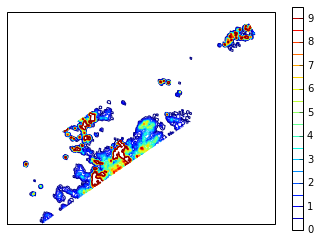

In [147]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contour(t.lon, t.lat, td,levels=np.arange(0,10,0.5), transform=ccrs.PlateCarree())

ax.coastlines()
cbar=plt.colorbar()

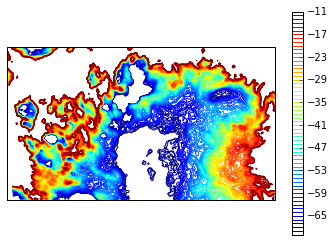

In [148]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contour(m.boxlon, m.boxlat ,d1,levels=np.arange(-70,-10,1), transform=ccrs.PlateCarree())

ax.coastlines()
cbar=plt.colorbar()

In [149]:
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
# Transform lon, lats to the mercator projection
x, y = pyproj.transform(salem.wgs84, proj, m.boxlon, m.boxlat)
# take the min and max
xmax, xmin = np.max(x), np.min(x)
ymax, ymin = np.max(y), np.min(y)
# Count the number of pixels
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx)
# Here one could add + 1 to be sure that the last pixel is always included
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)

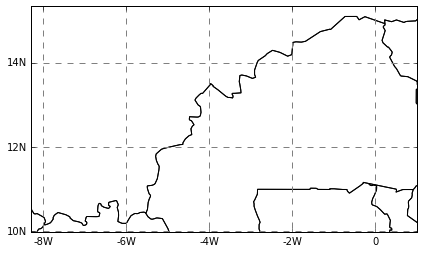

In [150]:
# cleo map
cm = cleo.Map(grid)
cm.visualize()

In [151]:
xi, yi = grid.ij_coordinates
lon, lat = grid.ll_coordinates

# Transform lons, lats to grid
xm, ym = grid.transform(m.boxlon.flatten(), m.boxlat.flatten(), crs=salem.wgs84)
xt, yt = grid.transform(t.lon.flatten(), t.lat.flatten(), crs=salem.wgs84)
        
# Convert for griddata input 
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T        

In [163]:
# Interpolate using delaunay triangularization 
outm = griddata(mpoints, d1.flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))
        
# Interpolate using delaunay triangularization 
outt = griddata(tpoints, td.flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx))      
         

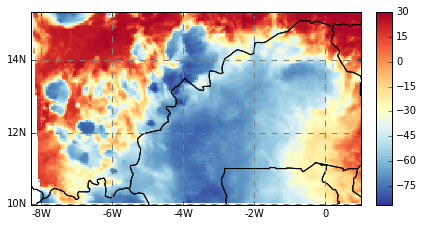

In [164]:
# reset map just in case
cm.set_data()
cm.set_cmap()
cm.set_geometry()
# show the data
cm.set_cmap(plt.cm.RdYlBu_r)
cm.set_nlevels(256)
cm.set_data(outm)
cm.visualize()

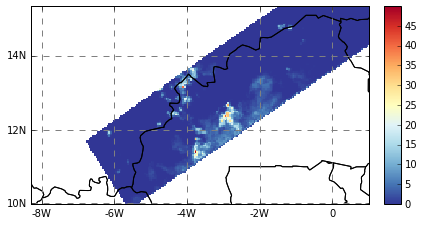

In [165]:
# reset map just in case
cm.set_data()
cm.set_cmap()
cm.set_geometry()
# show the data
cm.set_cmap(plt.cm.RdYlBu_r)
cm.set_nlevels(256)
cm.set_data(outt)
cm.visualize()

In [182]:
outt=outt[1:-1, 4:-4]
outm=outm[1:-1, 4:-4]

In [183]:
# zero lag
outt[np.isnan(outt)]=-10**-5
outm[np.isnan(outm)]=30     

In [184]:
outt.shape

(119, 199)

In [192]:
from wavelet import twod as w2d 
dt=5
dic= {}    
t=outm        
#2D continuous wavelet analysis:
#TIR   
tir=t.copy()     
tir[tir>0] = 0
tir = tir - np.mean(tir) 
mother2d = w2d.Mexican_hat()
    
powerTIR, scales2d, freqs2d = w2d.cwt2d(tir, dt, dt, dj=1./12, s0=30./mother2d.flambda(), J=45)
powerTIR[np.real(powerTIR>=0)] = 0.01
powerTIR = (np.abs(powerTIR)) ** 2 # Normalized wavelet power spectrum
period2d = 1. / freqs2d    
scales2d.shape = (len(scales2d),1,1)
powerTIR = powerTIR / (scales2d**2)
    
    

In [193]:
powerTIR.shape

(46, 119, 199)

In [194]:
#Precip
p=outt
powerPCP, scales2d, freqs2d = w2d.cwt2d(p, dt, dt, dj=1./12, s0=30./mother2d.flambda(), J=45)
powerPCP[np.real(powerPCP<=0)] = 0.01
powerPCP = (np.abs(powerPCP)) ** 2 # Normalized wavelet power spectrum
scales2d.shape = (len(scales2d),1,1)
powerPCP = powerPCP / (scales2d**2)
        


In [195]:
powerPCP.shape

(46, 119, 199)

In [196]:
dic['t']=powerTIR
dic['p']=powerPCP
dic['scales'] = (period2d/2.).round()

In [197]:
dic['t']

array([[[  1.75459634e-06,   8.25864843e+00,   1.53195591e+02, ...,
           1.75459634e-06,   1.75459634e-06,   1.75459634e-06],
        [  1.75459634e-06,   2.29387980e+01,   3.35171717e+02, ...,
           1.75459634e-06,   1.75459634e-06,   1.75459634e-06],
        [  1.75459634e-06,   1.18886852e+01,   2.98692694e+02, ...,
           1.75459634e-06,   1.75459634e-06,   1.75459634e-06],
        ..., 
        [  1.75459634e-06,   1.75459634e-06,   1.75459634e-06, ...,
           1.75459634e-06,   1.75459634e-06,   1.75459634e-06],
        [  1.75459634e-06,   1.75459634e-06,   1.75459634e-06, ...,
           1.75459634e-06,   1.75459634e-06,   1.75459634e-06],
        [  1.75459634e-06,   1.75459634e-06,   1.75459634e-06, ...,
           1.75459634e-06,   1.75459634e-06,   1.75459634e-06]],

       [[  1.56316763e-06,   6.53190153e+00,   1.36032693e+02, ...,
           1.56316763e-06,   1.56316763e-06,   1.56316763e-06],
        [  1.56316763e-06,   2.04228495e+01,   3.06275597e+0

In [19]:
dic=pkl.load( open ('/users/global/cornkle/timeshift.p', 'rb'))

In [20]:
corr=dic['corr']
dt=dic['dt']

In [21]:
corr[0:10]

[-0.042021416,
 -0.043131124,
 0.0017173864,
 -0.042526945,
 -0.041646942,
 0.39920494,
 -0.019918898,
 -0.019893155,
 0.0057473546,
 -0.060798101]

In [22]:
dt[0:10]

[4, -11, -26, -6, -21, -36, -2, -17, -32, -5]

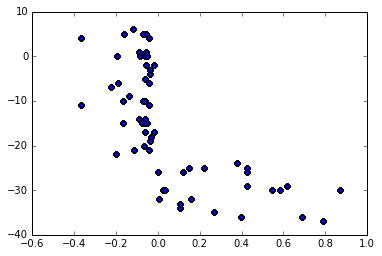

In [23]:
plt.scatter(corr, dt)

In [29]:
corr

[-0.042021416,
 -0.043131124,
 0.0017173864,
 -0.042526945,
 -0.041646942,
 0.39920494,
 -0.019918898,
 -0.019893155,
 0.0057473546,
 -0.060798101,
 -0.064206392,
 0.26738802,
 -0.087700695,
 -0.078202859,
 0.87165588,
 -0.16345388,
 -0.16643457,
 0.22265796,
 -0.057106055,
 -0.061172809,
 0.42413509,
 -0.09145195,
 -0.089058988,
 0.61691636,
 -0.05232159,
 -0.055117462,
 0.023193533,
 -0.12032429,
 -0.1385922,
 0.37770835,
 -0.22372632,
 -0.20032702,
 0.79005146,
 -0.058009993,
 -0.063606136,
 0.14784501,
 -0.071710654,
 -0.072728731,
 0.42665434,
 -0.055529468,
 -0.059462801,
 0.15834036,
 -0.05960463,
 -0.060690217,
 0.032504886,
 -0.3666614,
 -0.36709845,
 0.42748848,
 -0.042276528,
 -0.042749234,
 0.1200793,
 -0.18912302,
 -0.11278997,
 0.68800569,
 -0.052414402,
 -0.053089261,
 0.54751921,
 -0.1946273,
 -0.16571851,
 0.58357799,
 -0.038097773,
 -0.038174082,
 0.1080476,
 -0.036001854,
 -0.033681333,
 0.1063716,
 -0.042021416,
 -0.043131124,
 0.0017173864,
 -0.042526945,
 -0.04164

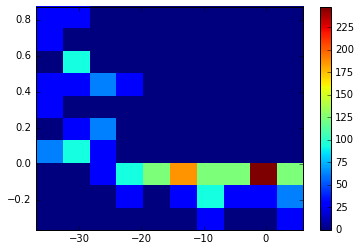

In [28]:
plt.hist2d(dt, corr, bins=10, cmap=plt.cm.jet)
plt.colorbar()